In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import snap
%matplotlib inline

In [3]:
def get_comm_info(comm_file):
    '''
    get community information, two maps
    map1: key: user id, value: community id array
    map2: key: community id, value: user id array
    '''
    comm_map_usr = {}
    comm_map_comm = {}
    comm_id = 0
    with open(comm_file, 'r') as cf:
        for line in cf:
            node_list = line.split('\t')
            node_list = [int(id) for id in node_list]
            for id in node_list:
                if id in comm_map_usr:
                    comm_map_usr[id].append(comm_id)
                else:
                    comm_map_usr[id] = [comm_id]
            comm_map_comm[comm_id] = node_list[:]
            comm_id += 1
    return comm_map_usr, comm_map_comm

In [4]:
gf_file = "data/com-lj.ungraph.txt"
gf = snap.LoadEdgeList(snap.PUNGraph, gf_file, 0, 1)

In [5]:
print "Load graph! With nodes ", gf.GetNodes(), " and edges ", gf.GetEdges()

Load graph! With nodes  3997962  and edges  34681189


In [6]:
comm_file = "data/com-lj.all.cmty.txt"
comm_map_usr, comm_map_comm = get_comm_info(comm_file)

In [7]:
##--collect degree distribution
degcnt = snap.TIntPrV()
snap.GetDegCnt(gf, degcnt)
deg_list = []
deg_cnt_list = []
total_deg = 0.
for item in degcnt:
    deg_list.append(item.GetVal1())
    deg_cnt_list.append(item.GetVal2())
    total_deg += item.GetVal2()
for i in xrange(len(deg_cnt_list)):
    deg_cnt_list[i] /= total_deg
    
deg_list = np.array(deg_list)
deg_cnt_list = np.array(deg_cnt_list)

In [8]:
##--perform linear regression on log degree distribution on the low degree
deg_list_log = np.log(deg_list)
deg_cnt_list_log = np.log(deg_cnt_list)

slope, intercept, r_value, p_value, std_err = stats.linregress( deg_list_log[:20], deg_cnt_list_log[:20])
print slope, intercept, r_value, p_value, std_err

-0.997131486255 -1.51656625202 -0.998284458996 1.21470767702e-23 0.0137845017917


In [9]:
##--perform linear regression on log degree distribution on the high degree
deg_list_log = np.log(deg_list)
deg_cnt_list_log = np.log(deg_cnt_list)

slope, intercept, r_value, p_value, std_err = stats.linregress( deg_list_log[100:800], deg_cnt_list_log[100:800])
print slope, intercept, r_value, p_value, std_err

-2.94901422139 5.94642638659 -0.984276359107 0.0 0.020031327841


In [10]:
##--prepare slope for degree distribution
degree_y_1 = np.exp(-1. * deg_list_log)
degree_y_2 = np.exp(-3. * deg_list_log) * 10000

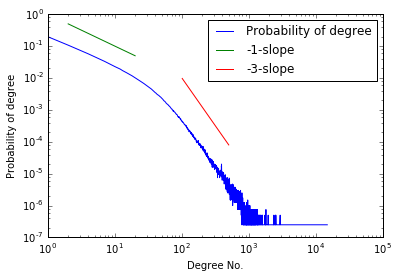

In [11]:
##--plotting
f1, = plt.loglog(deg_list, deg_cnt_list)
f2, = plt.loglog(deg_list[1:20], degree_y_1[1:20])
f3, = plt.loglog(deg_list[100:500], degree_y_2[100:500])
plt.xlabel("Degree No.")
plt.ylabel("Probability of degree")
f1.set_label("Probability of degree")
f2.set_label("-1-slope")
f3.set_label("-3-slope")
plt.legend()
plt.show()

In [40]:
##--probability of node in a community
prob_nod_comm = [0.] * int(np.amax(deg_list))

for ni in gf.Nodes():
    id = ni.GetId()
    deg = ni.GetDeg()
    if id in comm_map_usr:
        prob_nod_comm[deg - 1] += 1.

pd_list = [ deg +1 for deg in xrange(len(prob_nod_comm)) if snap.CntDegNodes(gf, deg+1) != 0]
prob_nod_comm = [ prob_nod_comm[deg] / snap.CntDegNodes(gf, deg+1) for deg in xrange(len(prob_nod_comm)) if snap.CntDegNodes(gf, deg+1) != 0]

In [48]:
##--perform linear regression on log degree distribution on the high degree
deg_list_log = np.log(deg_list)
prob_nod_comm_log = np.log(prob_nod_comm)

slope, intercept, r_value, p_value, std_err = stats.linregress( deg_list_log[0:31], prob_nod_comm_log[0:31])
print slope, intercept, r_value, p_value, std_err

0.725783931992 -2.95085059741 0.999645985464 3.10290006807e-47 0.00358714745471


/home/ggxh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [52]:
##--prepare slope for probability of nodes with certain degree in a community
prob_y_1 = np.exp(0.726 * deg_list_log) /10

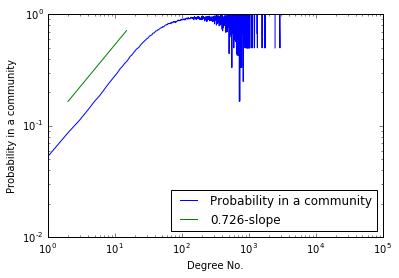

In [64]:
##--plotting
f1, = plt.loglog(deg_list, prob_nod_comm)
f2, = plt.loglog(deg_list[1:15], prob_y_1[1:15])
plt.xlabel("Degree No.")
plt.ylabel("Probability in a community")
f1.set_label("Probability in a community")
f2.set_label("0.726-slope")
plt.legend(loc=4)
plt.show()

In [38]:
snap.CntDegNodes(gf, 14815)

1